In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import os
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm
import random
import torch.nn as nn
from dataset import Thyroid_Dataset
from model import Eff_Unet
from HarDMSEG import HarDMSEG
from loss_metric import DiceLoss, IOU_score, StructureLoss
from LightMed.model.LightMed import LightMed
from PMFSNet.lib.models.PMFSNet import PMFSNet
from PMFSNet.lib.models.PMFSNet_FFT import PMFSNet_FFT
from hybrid_model_v3 import HybridSegModel

/home/twszbak764/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/twszbak764/.local/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/twszbak764/.local/lib/python3.12/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [49]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import os
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms.functional as tx
import random
import cv2
from PIL import ImageEnhance
from skimage.exposure import match_histograms
import torchvision.transforms as T
import torchvision.transforms.functional as F
class Gland_Dataset(Dataset):
    def __init__(self, csv_file, transform, image_size):
        self.df = pd.read_csv(csv_file)
        self.transform = transform
        self.image_size = image_size
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_name = self.df["image_name"][idx]
        mask_name = self.df["mask_name"][idx]

        from_folder = "../gland_data"
        
        image_path = f"{from_folder}/images/{image_name}"
        mask_path = f"{from_folder}/masks/{mask_name}"

        image = Image.open(image_path).convert("L")
        mask = Image.open(mask_path).convert("L")
        
        image_tensor, mask_tensor = self.transform(image, mask, self.image_size)
        mask_tensor = (mask_tensor > 0.5).float()
        if torch.sum(mask_tensor) == 0:
            # print("nothing")
            return [None]
        return image_tensor, mask_tensor


In [51]:
image_size = 128
batch_size = 1
def test_augmentation(image, mask, image_size):
    resize = T.Resize((image_size, image_size))
    image = resize(image)
    mask = resize(mask)

    image_tensor = tx.to_tensor(image)
    mask_tensor = tx.to_tensor(mask)

    # If standardization
    mean = image_tensor.mean()
    std = image_tensor.std()
    std = std if std > 0 else 1.0  # avoid division by zero
    image_tensor = (image_tensor - mean) / std
    return image_tensor, mask_tensor
def custom_collate_fn(batch):
    # print(batch)
    filtered_batch = [item for item in batch if item[0] is not None]
    if len(filtered_batch) == 0:
        return [None, None]
    return torch.utils.data.dataloader.default_collate(filtered_batch)

test_dataset = Gland_Dataset("../gland_data/benq_test.csv", transform = test_augmentation, image_size = image_size)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True, collate_fn=custom_collate_fn)

image, mask = next(iter(test_dataloader))

In [52]:
len(test_dataloader)

158

In [53]:
import torch
import numpy as np
import cv2

import torch
import numpy as np
import cv2

def postprocess_logits_mask(logits_mask, threshold=0.5):
    """
    logits_mask: torch.Tensor of shape [B, 1, H, W], raw logits
    threshold: value for converting logits to binary mask after sigmoid
    returns: torch.Tensor of shape [B, 1, H, W] with only the largest component retained
    """
    # Step 1: Convert logits to probabilities
    prob_mask = torch.sigmoid(logits_mask)

    # Step 2: Threshold to get binary mask
    binary_mask = (prob_mask > threshold).float()

    # Step 3: Remove all but the largest connected component
    binary_mask = binary_mask.squeeze(1)  # [B, H, W]
    cleaned_batch = []

    for mask in binary_mask:
        mask_np = mask.cpu().numpy().astype(np.uint8)
        num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask_np, connectivity=8)

        if num_labels <= 1:
            cleaned = np.zeros_like(mask_np)
        else:
            largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
            cleaned = (labels == largest_label).astype(np.uint8)

        cleaned_batch.append(torch.from_numpy(cleaned))

    # Stack and return to original shape [B, 1, H, W]
    cleaned_mask = torch.stack(cleaned_batch).unsqueeze(1).float().to(logits_mask.device)

    return cleaned_mask
import torch
import numpy as np
import cv2
from scipy.ndimage import binary_fill_holes

def postprocess_logits_with_fill(logits_mask, threshold=0.5):
    """
    logits_mask: torch.Tensor of shape [B, 1, H, W], raw logits
    returns: torch.Tensor of shape [B, 1, H, W], cleaned mask
    """
    # Step 1: Apply sigmoid + threshold
    prob_mask = torch.sigmoid(logits_mask)
    binary_mask = (prob_mask > threshold).float()
    binary_mask = binary_mask.squeeze(1)  # [B, H, W]
    
    cleaned_batch = []

    for mask in binary_mask:
        mask_np = mask.cpu().numpy().astype(np.uint8)
        
        # Step 2: Keep largest connected component
        num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask_np, connectivity=8)
        if num_labels <= 1:
            largest_component = np.zeros_like(mask_np)
        else:
            largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
            largest_component = (labels == largest_label).astype(np.uint8)
        
        # Step 3: Fill holes in the largest component
        filled = binary_fill_holes(largest_component).astype(np.uint8)

        cleaned_batch.append(torch.from_numpy(filled))

    return torch.stack(cleaned_batch).unsqueeze(1).float().to(logits_mask.device)

# 
# Only calculate nodule loss, IOU, DICE, because there is no gland data in the testing set
def val(dataloader, model, loss_fn, device, post_process = False):
    total_loss = 0
    
    total_IOU = 0
    
    total_DICE = 0

    model.eval()
    model.to(device)
    count = 0
    for image, mask in tqdm(dataloader):
        if image == None:
            continue
        image, mask = image.to(device), mask.to(device)
        
        outputs = model(image)
        
        output = outputs[:, 1:2, :, :]
        
        loss = loss_fn(output, mask)
        
        if post_process:
            output = postprocess_logits_with_fill(output)
            IOU = IOU_score(output, mask, need_act = False)
    
            dice_loss = DiceLoss(need_act = False)
            DICE = 1 - dice_loss(output, mask)
        else:
            IOU = IOU_score(output, mask)
    
            dice_loss = DiceLoss()
            DICE = 1 - dice_loss(output, mask)

        total_loss += loss.item()
        
        total_IOU += IOU.item()
        
        total_DICE += DICE.item()
        count += 1
    # print(count)
    return total_loss/count, total_IOU/count, total_DICE/count


    

In [80]:
# inference_name = "models/finetune/ge_benq/hybrid_model_ge_benq_baseline(1)_freeze_encoder_wo_zeromask_aug_colorjitter_affine_crop"
inference_name = "models/finetune/gland/hybrid_model_gland_baseline(0.3)_freeze_encoder_wo_zeromask"
# inference_name = "models/finetune/gland/test"
model = HybridSegModel(in_channels = 1, out_channels = 2, output_size = image_size, layers_num = 3)
checkpoint = torch.load(f"{inference_name}/best_checkpoint.pth")
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [81]:
# loss_fn = DiceLoss()
loss_fn = StructureLoss()


In [82]:
total_loss_val, total_IOU_val, total_DICE_val = val(test_dataloader, model, loss_fn, "cuda", post_process = False)
print(f"val loss : {total_loss_val}, val IOU : {total_IOU_val}, val DICE : {total_DICE_val}")

100%|██████████| 158/158 [00:03<00:00, 46.74it/s]

val loss : 0.7152708685499126, val IOU : 0.55525729057016, val DICE : 0.6834310257838945


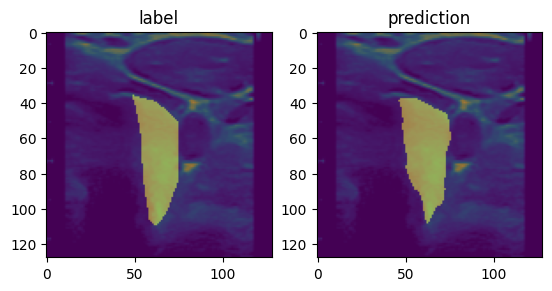

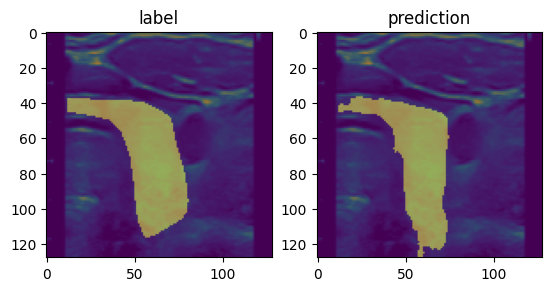

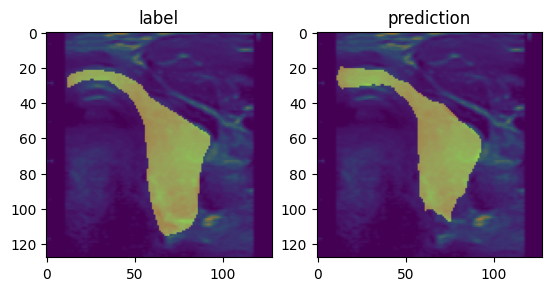

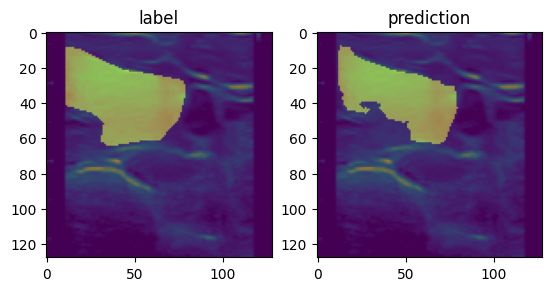

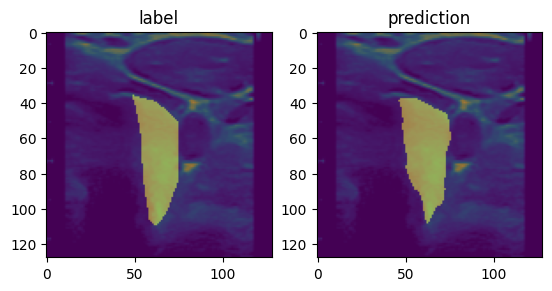

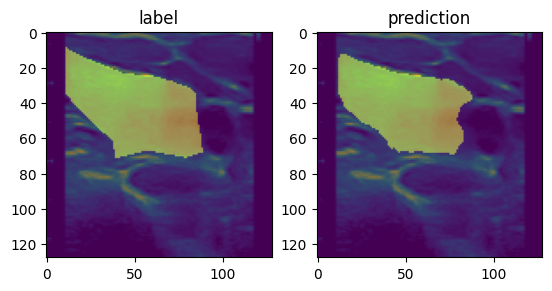

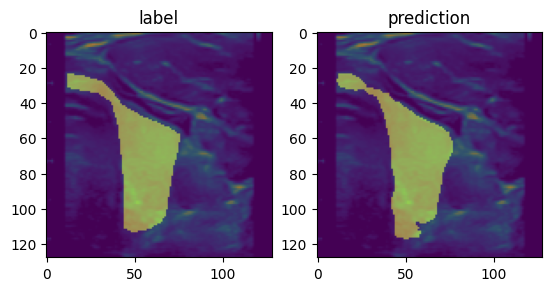

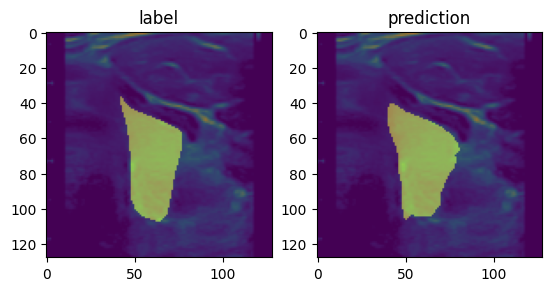

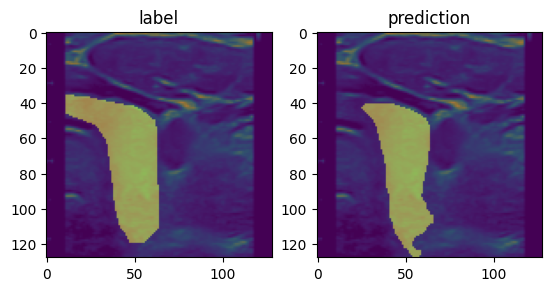

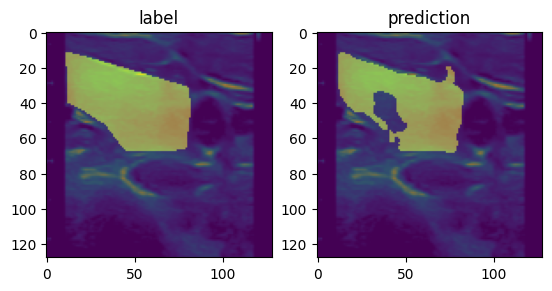

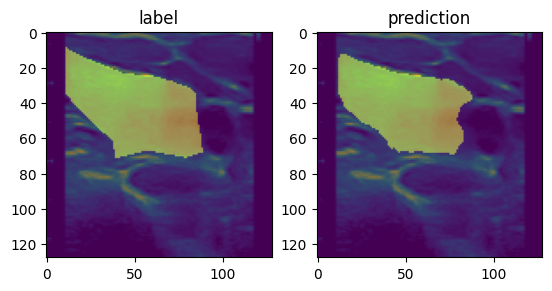

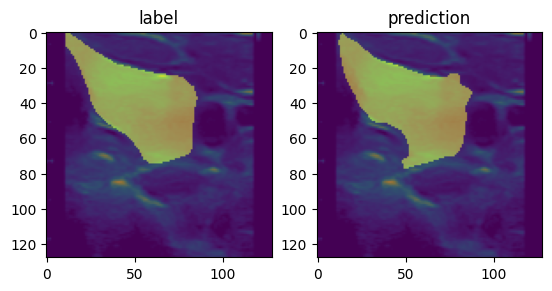

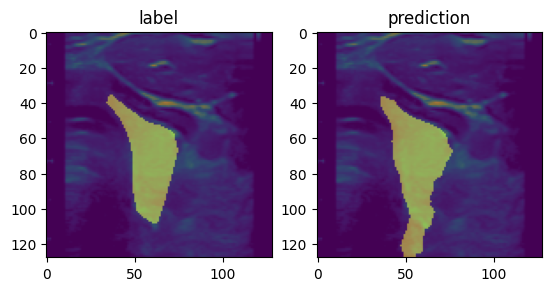

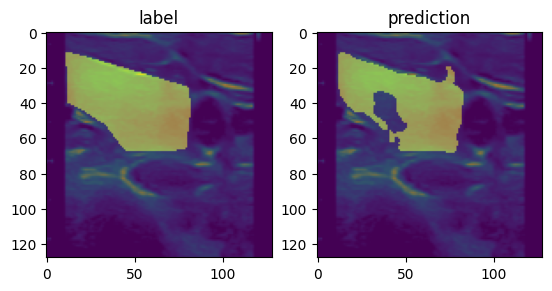

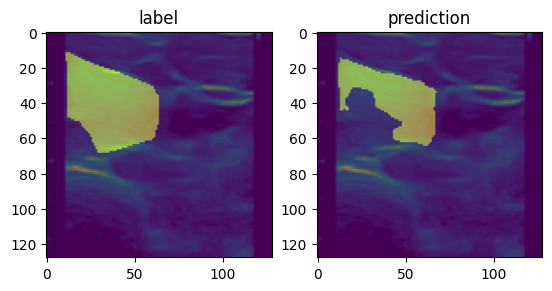

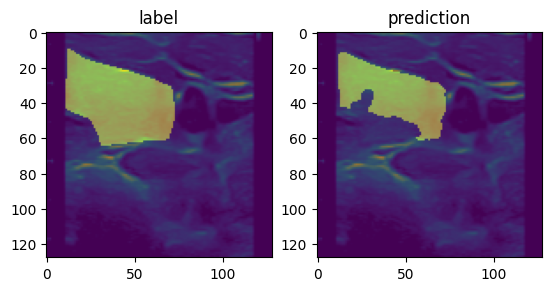

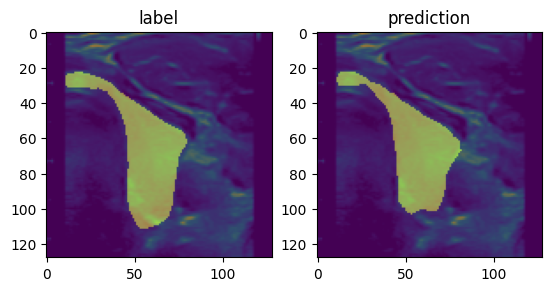

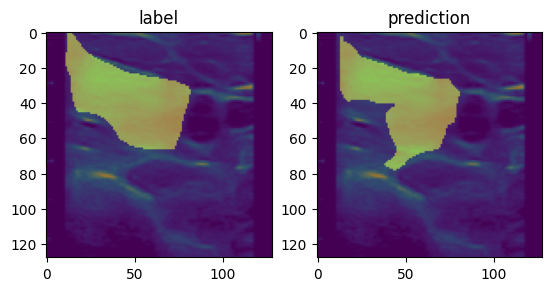

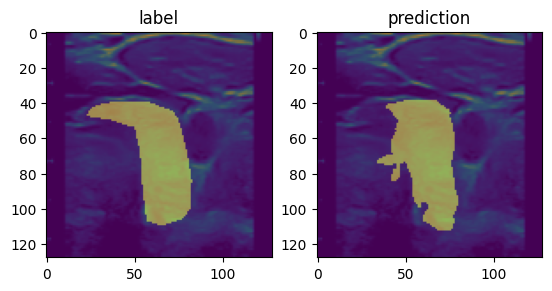

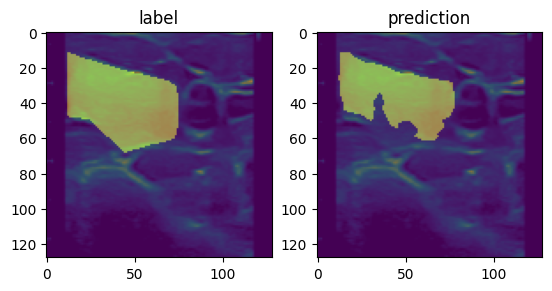

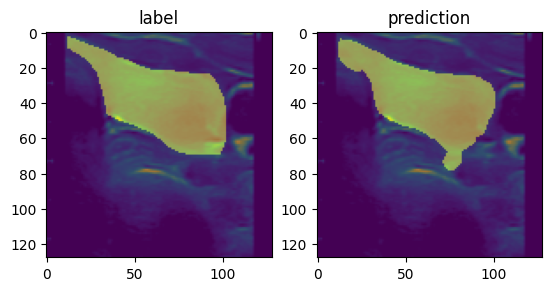

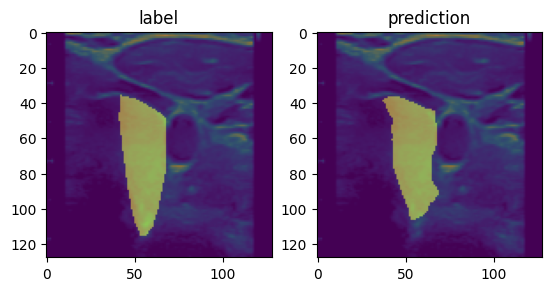

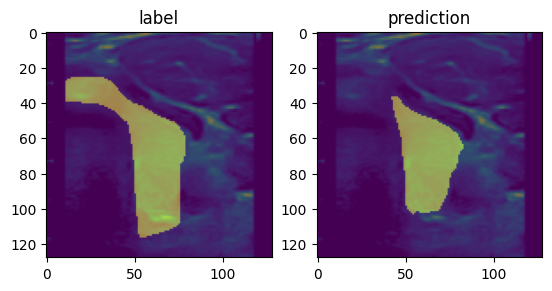

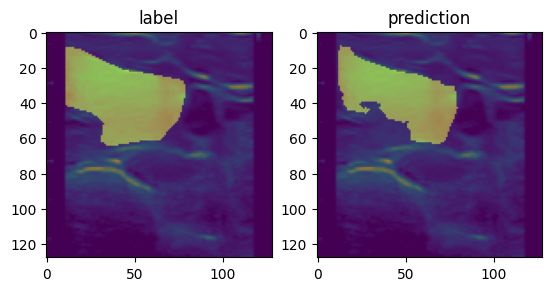

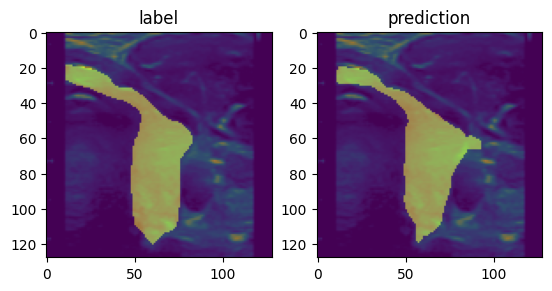

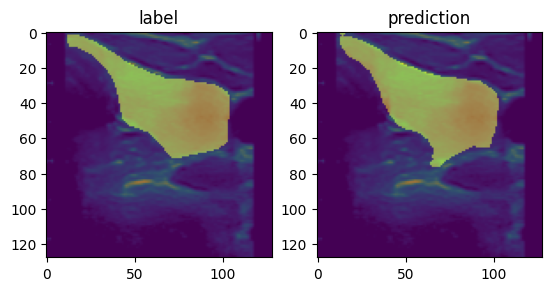

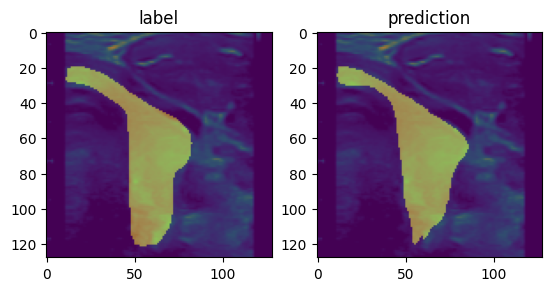

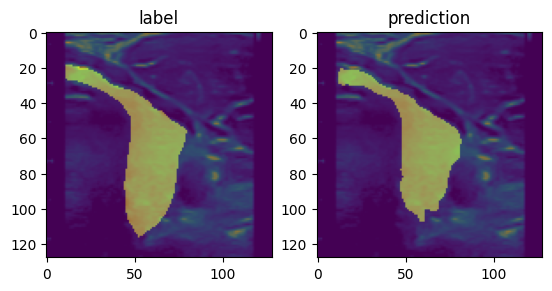

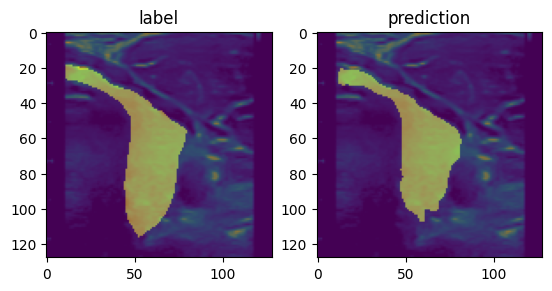

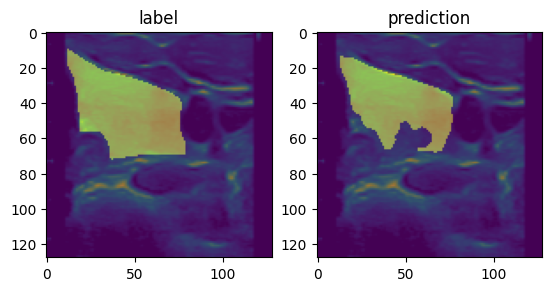

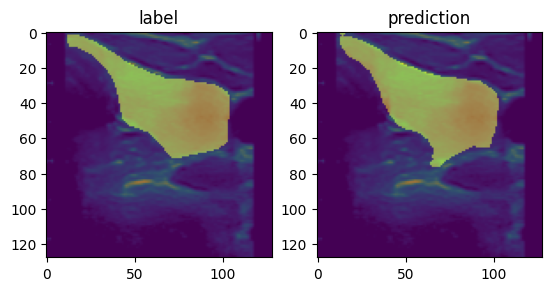

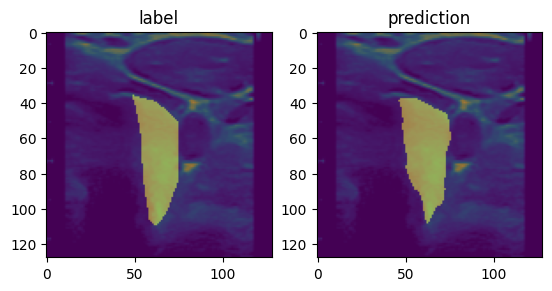

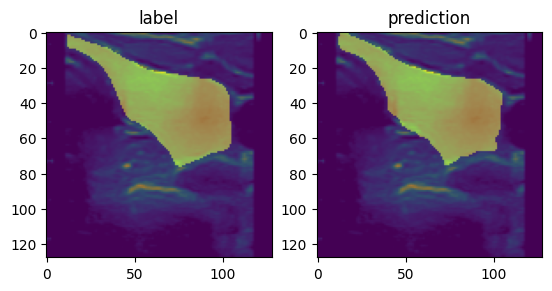

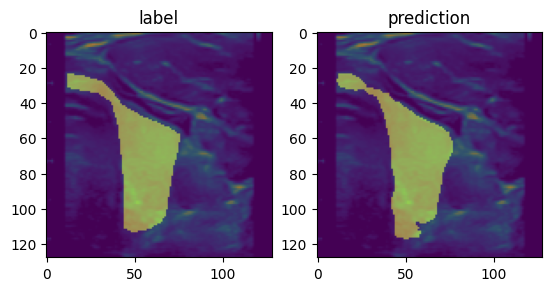

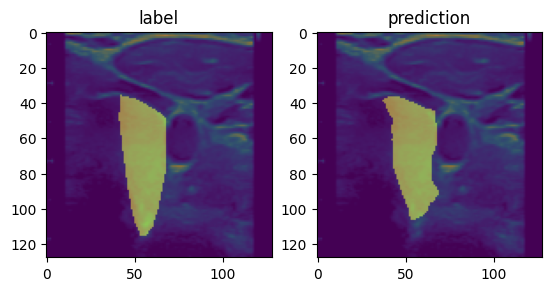

In [23]:
count = 0
model.eval()
while count < 50:
    image, mask = next(iter(test_dataloader))
    if image == None:
        continue
    model.to("cpu")
    outputs = model(image)
    outputs = outputs[:, 1:2]

    outputs = postprocess_logits_with_fill(outputs)
    # outputs = nn.Sigmoid()(outputs).float()
    # outputs = outputs > 0.5
    count+=1
    plt.subplot(1,2,1)
    plt.imshow(image[0][0])
    plt.imshow(mask[0][0], alpha = 0.5)
    plt.title("label")
    
    plt.subplot(1,2,2)
    plt.imshow(image[0][0])
    plt.imshow(outputs[0][0].detach().cpu().numpy(), alpha = 0.5)
    plt.title("prediction")
    plt.show()

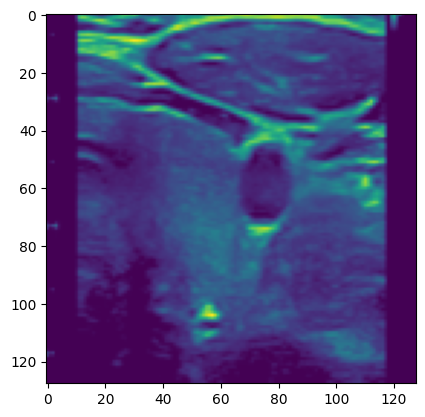

In [24]:

plt.imshow(image[0][0])

In [39]:
def sharpen_image(image_np):
    """
    image_np: 2D NumPy array (grayscale ultrasound image)
    returns: sharpened 2D NumPy array
    """
    # Sharpening kernel (emphasizes center, subtracts surroundings)
    kernel = np.array([[0, -1,  0],
                       [-1,  5, -1],
                       [0, -1,  0]])
    
    sharpened = cv2.filter2D(image_np, -1, kernel)
    return sharpened

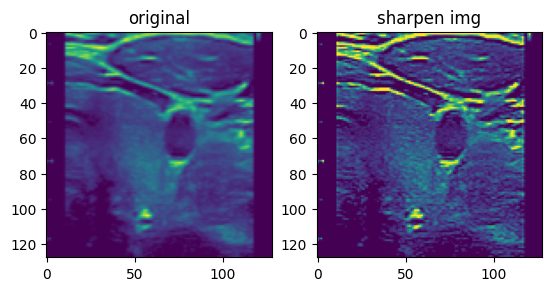

In [40]:
img = image[0][0].detach().cpu().numpy()

img = (img - img.min()) / (img.max() - img.min())
img_uint8 = (img * 255).astype(np.uint8)

sharp_img = sharpen_image(img_uint8)
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("original")
plt.subplot(1,2,2)
plt.imshow(sharp_img)
plt.title("sharpen img")
plt.show()